In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
import os
#import xgboost as xgb
#import lightgbm as lgb
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import gc
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')


In [2]:
os.listdir('dataset-0510/')

['fields.pdf',
 'Result.xlsx',
 'test.csv',
 'train.csv',
 '~$Result.xlsx',
 '下載 (1).png',
 '下載 (2).png',
 '下載 (3).png',
 '下載 (4).png',
 '下載.png']

In [3]:
train = pd.read_csv('dataset-0510/train.csv')
test  = pd.read_csv('dataset-0510/test.csv')
data = pd.concat([train, test], axis=0)
gc.collect()

13

In [51]:
def feature_process(df):
    
    #Impute missing value
    #df['village_income_median'] = df.groupby(['city', 'town'])['village_income_median'].transform(lambda x : x .fillna(x.median()))
    df['village_income_mean'] = df.groupby(['city', 'town'])['village_income_median'].transform(lambda x : x .fillna(x.mean()))
    
    #floor
    df.loc[df['txn_floor'].isna(), 'department'] = 1 
    df.loc[df['txn_floor'].notna(), 'department'] = 0
    df.loc[df['txn_floor'].isna(), 'txn_floor'] = df.loc[df['txn_floor'].isna(), 'total_floor']
    df['avg_height_floor'] = df['txn_floor'] / df['total_floor'] 
    df['avg_height_floor'].fillna(1, inplace = True)
    
    #village_income_median
    '''
    temp = df.groupby(['city', 'town', 'village'])['village_income_median'].first().reset_index()
    temp = df.groupby(['city', 'town']).agg({'village_income_median' : ['mean', 'sum', 'median']})
    temp = temp.rename({'village_income_median_sum' : 'town_income_median_sum'})
    temp.columns = [e[0] + '_' + e[1] if e[1] != '' else e[0] for e in temp.columns.tolist()]
    df = pd.merge(df, temp, on = ['city', 'town'], how = 'left')

    temp = df.groupby(['city', 'town', 'village'])['village_income_median'].first().reset_index()
    temp = df.groupby(['city']).agg({'village_income_median' : ['mean', 'sum', 'median']})
    temp = temp.rename({'village_income_median_sum' : 'city_income_median_sum'})
    temp.columns = [e[0] + '_' + e[1] if e[1] != '' else e[0] for e in temp.columns.tolist()]
    df = pd.merge(df, temp, on = ['city'], how = 'left')
    '''
    
    
    #location
    #df['location_1'] = df.apply(lambda x : int(str(x['city']) + str(x['town']) + str(x['village'])), axis=1)
    df['location_2'] = df.apply(lambda x : int(str(x['city']) + str(x['town'])), axis=1)
    df['city'] = df['city'].astype('category')
    df['location_2'] = df['location_2'].astype('category')
    
    #date
    df['day_between_txn_complete'] = df['txn_dt'] - df['building_complete_dt']
    
    df['year_between_txn_complete'] = round(df['day_between_txn_complete'] / 365)
    
    
    #parking
    df['miss_parking_area'] = 0
    df['miss_parking_price'] = 0
    df.loc[df['parking_area'].isna(), 'miss_parking_area'] = 1
    df.loc[df['parking_price'].isna(), 'miss_parking_price'] = 1
    df['parking_price_every_area'] = df['parking_price'] / df['parking_area']
    df['parking_way'] = df['parking_way'].astype('category')
    #df = df.join(pd.get_dummies(df['parking_way'], prefix = 'parking_way'))
    df['parking_area'].fillna(0, inplace =True)
    df['parking_price'].fillna(0, inplace =True)
    
    #area
    df['land/bulid_area'] = df['land_area'] / df ['building_area']
    df['house_area'] = df['building_area'] - df['parking_area'] 
    df['house_rate'] = df['building_area'] / df['house_area']
    
    df['area_rate'] = df['land_area'] / df['town_area']
    
    #population
    
    #soical rate
    df['natural_diff'] = df['born_rate'] - df['death_rate']
    df['natural_rate'] = df['born_rate'] / df['death_rate']
    
    df['marry_diff'] = df['marriage_rate'] - df['divorce_rate']
    df['marry_rate'] = df['marriage_rate'] / df['divorce_rate']
    
    df['total_diff_sum'] = df['natural_rate'] + df['marry_diff']
    df['total_diff_diff'] = df['natural_rate'] - df['marry_diff']
    df['total_rate_diff'] = df['born_rate'] + df['marry_rate']
    
    df['positive_grow_rate'] = df['born_rate'] + df['marriage_rate']
    df['negative_grow_rate'] = df['death_rate'] + df['divorce_rate']
    df['tatal_rate_sum'] = df['born_rate'] + df['death_rate'] + df['born_rate'] + df['death_rate']
    
    #building   #building_type = 4 is house
    df['building_type'] = df['building_type'].astype('category')
    #df = df.join(pd.get_dummies(df['building_type'], prefix = 'building_type'))
    df['building_material'] = df['building_material'].apply(lambda x : 2 if x not in [1,8] else x)
    df['building_use'] = df['building_use'].apply(lambda x : 2 if x not in [1,2,5] else x)
    df['building_material'] = df['building_material'].astype('category')
    df['building_use'] = df['building_use'].astype('category')
    
    #degree rate
    df['diff_doc_master'] = df['doc_rate'] - df['master_rate']
    df['diff_master_bachelor'] = df['master_rate'] - df['bachelor_rate']
    df['diff_bachelor_highsch'] = df['bachelor_rate'] - df['highschool_rate']
    df['diff_highsch_jobschool'] = df['highschool_rate'] - df['jobschool_rate']
    df['diff_jobschool_elesch'] = df['jobschool_rate'] - df['elementary_rate']
    
    df['all_degree'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] + df['jobschool_rate'] + df['junior_rate'] + df['elementary_rate']
    df['junior_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] + df['jobschool_rate'] + df['junior_rate'] 
    df['jobschool_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] +  df['jobschool_rate']
    df['highschool_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate']
    df['bachelor_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate']
    df['master_above_rate'] = df['doc_rate'] + df['master_rate'] 
    
    #MIN
    MIN_cols = [i for i in df.columns if '_MIN' in i]
    df[MIN_cols].apply(lambda x : x.mean(), axis =1 )
    df[MIN_cols].apply(lambda x : x.median(), axis =1 )
    df[MIN_cols].apply(lambda x : x.std(), axis =1 )
    df[MIN_cols].apply(lambda x : x.skew(), axis =1 )
    
    rank_df = df[MIN_cols].rank(axis =1)
    rank_df = rank_df.add_prefix('Rank_')
    df = pd.concat([df, rank_df], axis=1)
    
    #10 50 100 250 500 1000 5000 10000
    df['diff_500_50'] = df['N_500'] - df['N_50']
    df['diff_1000_500'] = df['N_1000'] - df['N_500']
    df['diff_5000_1000'] = df['N_5000'] - df['N_1000']
    df['diff_10000_5000'] = df['N_10000'] - df['N_5000']
    df['rate_500_50'] = df['N_500'] / df['N_50']
    df['rate_1000_500'] = df['N_1000'] / df['N_500']
    df['rate_5000_1000'] = df['N_5000'] / df['N_1000']
    df['rate_10000_5000'] = df['N_10000'] / df['N_5000']
    
    
    All_10    = [i for i in df.columns if i.endswith('_10') and 'index' not in i and 'N' not in i]
    All_50    = [i for i in df.columns if i.endswith('_50') and 'index' not in i and 'N' not in i]
    All_100   = [i for i in df.columns if i.endswith('_100') and 'index' not in i and 'N' not in i]
    All_250   = [i for i in df.columns if i.endswith('_250') and 'index' not in i and 'N' not in i]
    All_500   = [i for i in df.columns if i.endswith('_500') and 'index' not in i and 'N' not in i]
    All_1000  = [i for i in df.columns if i.endswith('_1000') and 'index' not in i and 'N' not in i]
    All_5000  = [i for i in df.columns if i.endswith('_5000') and 'index' not in i and 'N' not in i]
    All_10000 = [i for i in df.columns if i.endswith('_10000') and 'index' not in i and 'N' not in i]
    df['All_10'] = reduce(lambda x, y: x + y, [df[i] for i in All_10])
    df['All_50'] = reduce(lambda x, y: x + y, [df[i] for i in All_50])
    df['All_100'] = reduce(lambda x, y: x + y, [df[i] for i in All_100])
    df['All_250'] = reduce(lambda x, y: x + y, [df[i] for i in All_250])
    df['All_500'] = reduce(lambda x, y: x + y, [df[i] for i in All_500])
    df['All_1000'] = reduce(lambda x, y: x + y, [df[i] for i in All_1000])
    df['All_5000'] = reduce(lambda x, y: x + y, [df[i] for i in All_5000])
    df['All_10000'] = reduce(lambda x, y: x + y, [df[i] for i in All_10000])
    '''
    for i,j in zip([All_10, All_50, All_100, All_250, All_500, All_1000, All_5000], [All_50, All_100, All_250, All_500, All_1000, All_5000, All_10000]):
        for order in range(len(i)):
            df[j[order] + '_' + i[order] + '_diff'] = df[j[order]] - df[i[order]]
            df[j[order] + '_' + i[order] + '_rate'] = df[j[order]] / df[i[order]]
   ''' 
    #interection
    
    '''
    inter_cols = ['building_type', 'parking_way', 'building_use', 'building_material']
    for i in range(4):
        for j in range(4):
            if j > i:
                df['inter_btw_' + inter_cols[i] +'_' + inter_cols[j]] = df.apply(lambda x : str(x[inter_cols[i]]) + str(x[inter_cols[j]]), axis=1)
                df['inter_btw_' + inter_cols[i] +'_' + inter_cols[j]] = df['inter_btw_' + inter_cols[i] +'_' + inter_cols[j]].astype('category')
    '''
    
    #groupby encoding
    
    category_cols  = ['building_material',
                      'building_type',
                      'building_use',
                      'city',
                      'parking_way']
    
    numerical_cols = ['building_area', 'land_area', 'day_between_txn_complete', 'txn_dt', 'building_complete_dt', 'house_area', 'house_rate']
    statistics = ['mean', 'median', 'max', 'min']
    for category in category_cols:
        for numerical in numerical_cols:
            for stat in statistics:
                df[numerical + '_' + stat + '_gb_' + category] = df.groupby([category])[numerical].transform(stat)
                df[numerical + '_diff_' + stat + '_gb_' + category] = df[numerical] - df[numerical + '_' + stat + '_gb_' + category]
                df.drop([numerical + '_' + stat + '_gb_' + category], inplace = True, axis = 1)
    
    '''
    category_cols =['city', 'location_2']
    count_cols = ['building_type', 'building_use', 'building_material', 'parking_way']
    for category in category_cols:
        for count_col in count_cols:
            df['size_gb_' + category + '_' + count_col] = df.groupby([category, count_col])[count_col].transform('size')
    '''
    
    #df['parking_price'] = df.groupby(['building_type', 'parking_way'])['parking_price'].transform(lambda x : x.median())

    
    #Polynomail feature
    
    
    #useless cols
    df.drop(['village'], axis = 1, inplace = True)
    df.drop([i for i in train.columns if np.sum(train[i]) == 60000 and 'index' in i], axis = 1, inplace = True)
    return df

In [52]:
FE_data = feature_process(data)
FE_train = FE_data[:60000]
FE_test = FE_data[60000:]
FE_train.to_csv('FE_train.csv', index = False)
FE_test.to_csv('FE_test.csv', index = False)
len(FE_train.columns), len(FE_test.columns)

(416, 416)

In [53]:
len(FE_train), len(FE_test)

(60000, 10000)

In [54]:
gc.collect()

152

In [38]:
[i for i in FE_train.columns if FE_train[i].dtypes not in ['float64', 'int64', 'O']]

['building_material',
 'building_use',
 'city',
 'location_2',
 'parking_way_0',
 'parking_way_1',
 'parking_way_2',
 'building_type_0',
 'building_type_1',
 'building_type_2',
 'building_type_3',
 'building_type_4']

In [37]:
FE_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 3749
Columns: 421 entries, III_10 to house_rate_diff_min_gb_parking_way
dtypes: category(4), float64(185), int64(223), object(1), uint8(8)
memory usage: 188.4+ MB


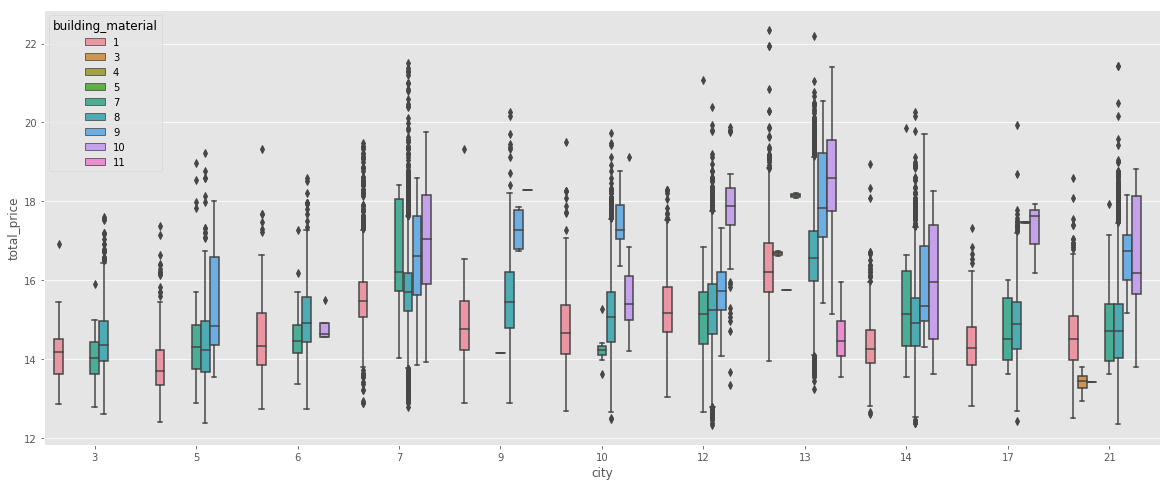

In [26]:
fig = plt.figure(figsize=(20,8))
sns.boxplot(x = train['city'], y = np.log1p(train['total_price']), hue = train['building_material'])

In [ ]:
train['buil'].value_counts()

In [4]:
train['building_material'].value_counts()

8     52609
1      6372
10      462
7       375
9       167
3         7
11        4
5         2
4         2
Name: building_material, dtype: int64

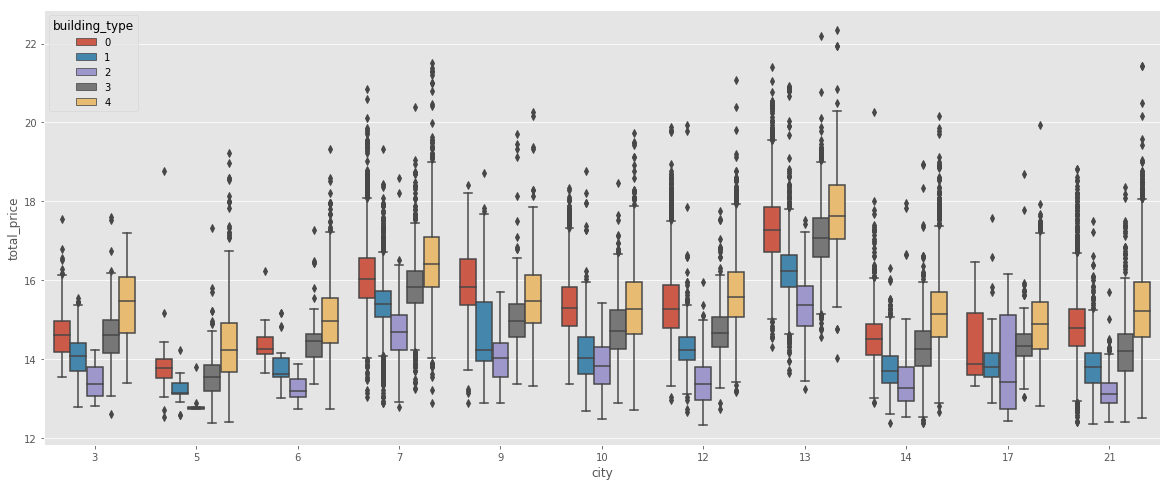

In [81]:
fig = plt.figure(figsize=(20,8))
sns.boxplot(x = train['city'], y = np.log1p(train['total_price']), hue = train['building_type'])

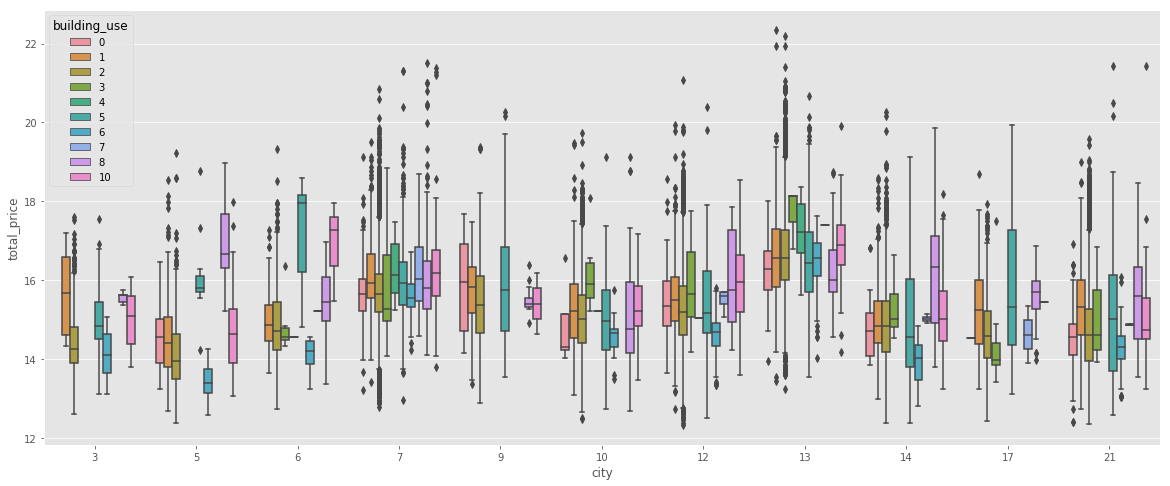

In [82]:
fig = plt.figure(figsize=(20,8))
sns.boxplot(x = train['city'], y = np.log1p(train['total_price']), hue = train['building_use'])

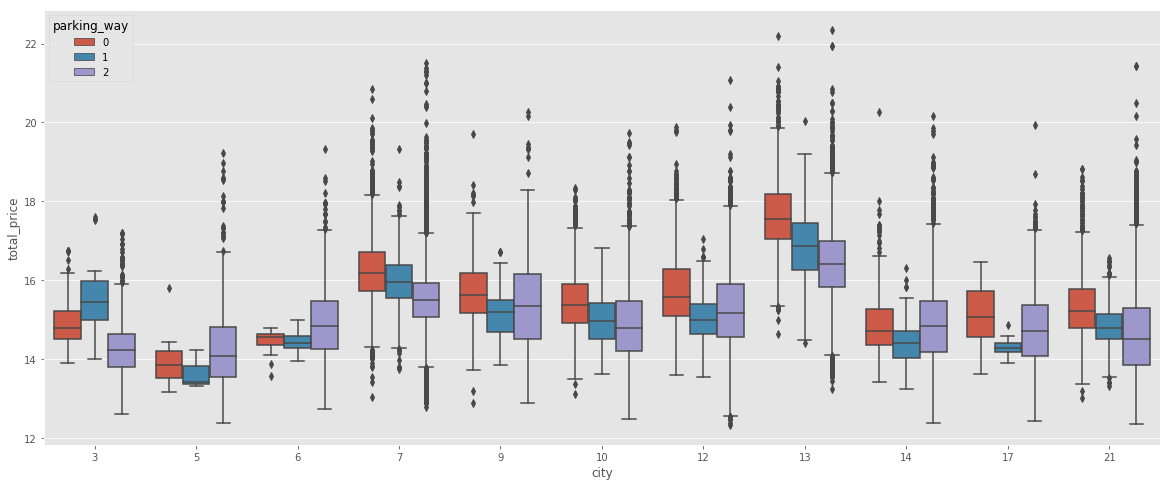

In [83]:
fig = plt.figure(figsize=(20,8))
sns.boxplot(x = train['city'], y = np.log1p(train['total_price']), hue = train['parking_way'])

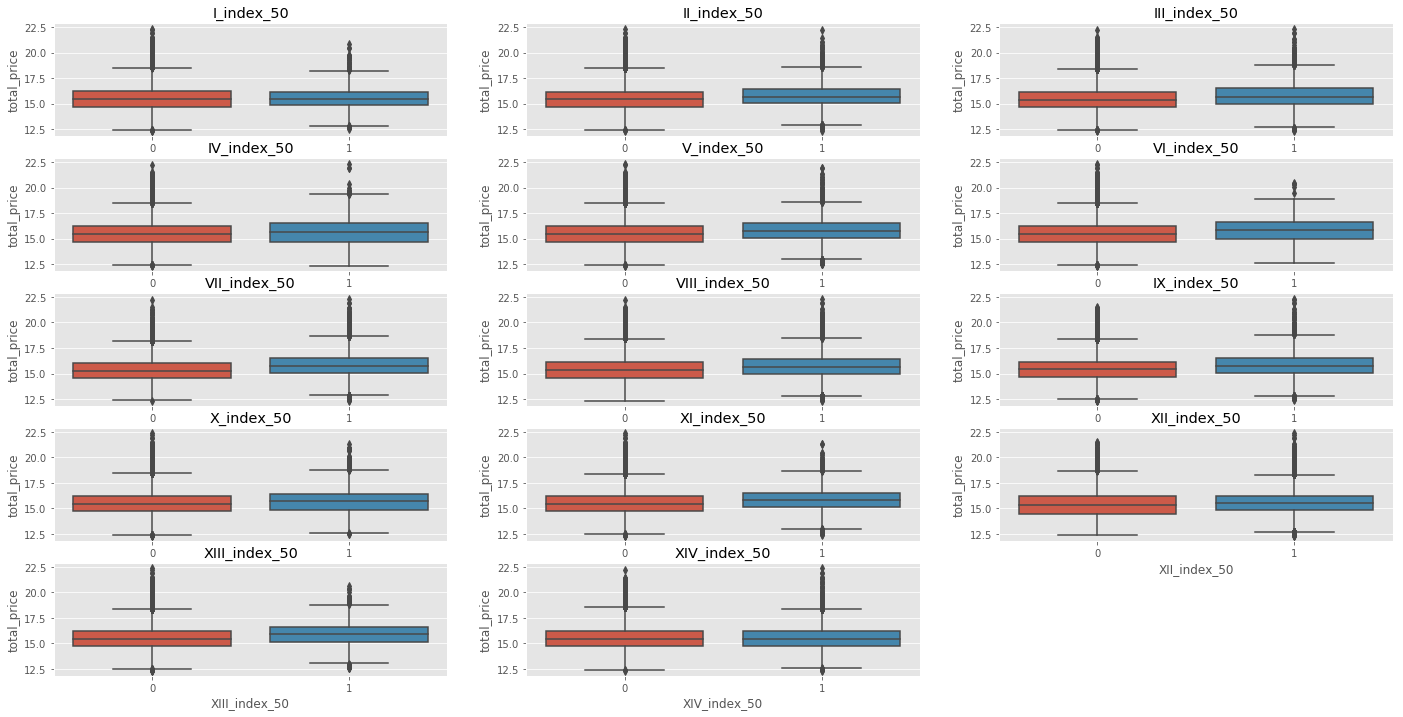

In [27]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_50')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], np.log1p(train['total_price']))

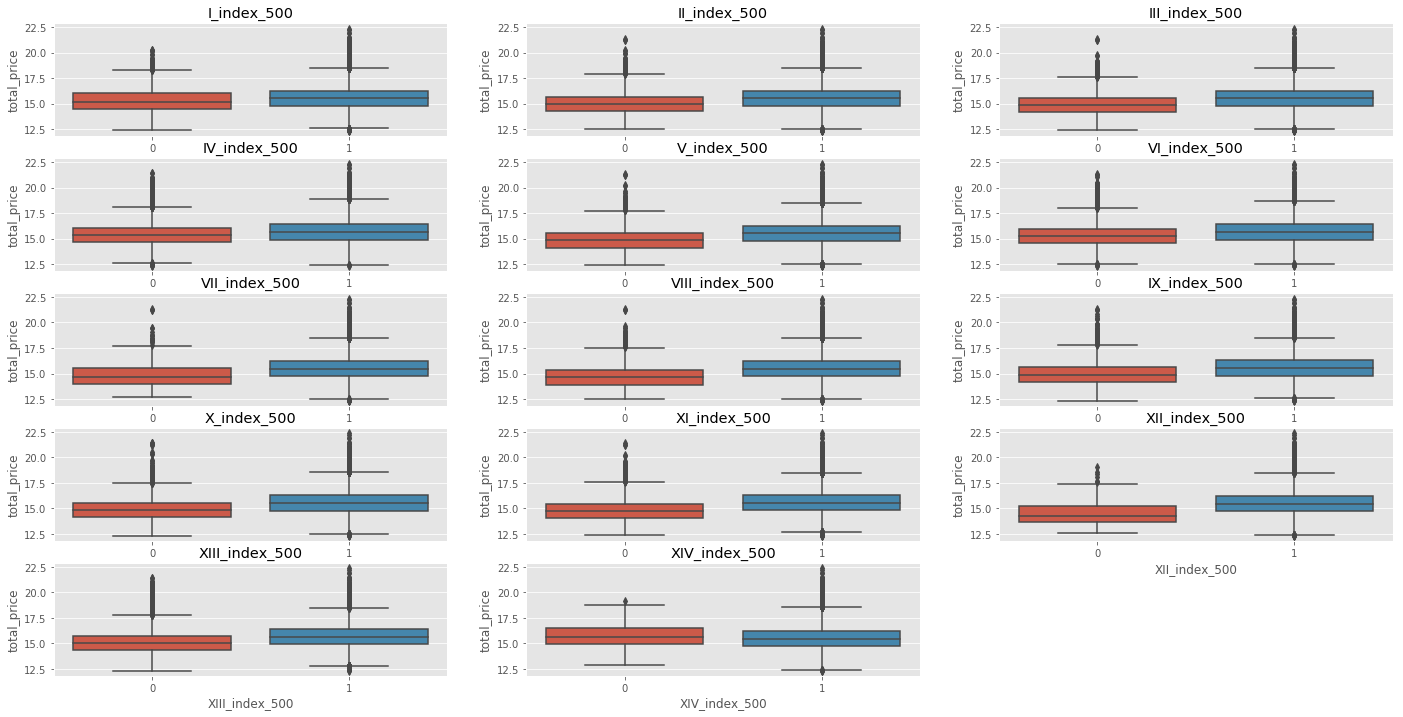

In [28]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_500')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], np.log1p(train['total_price']))

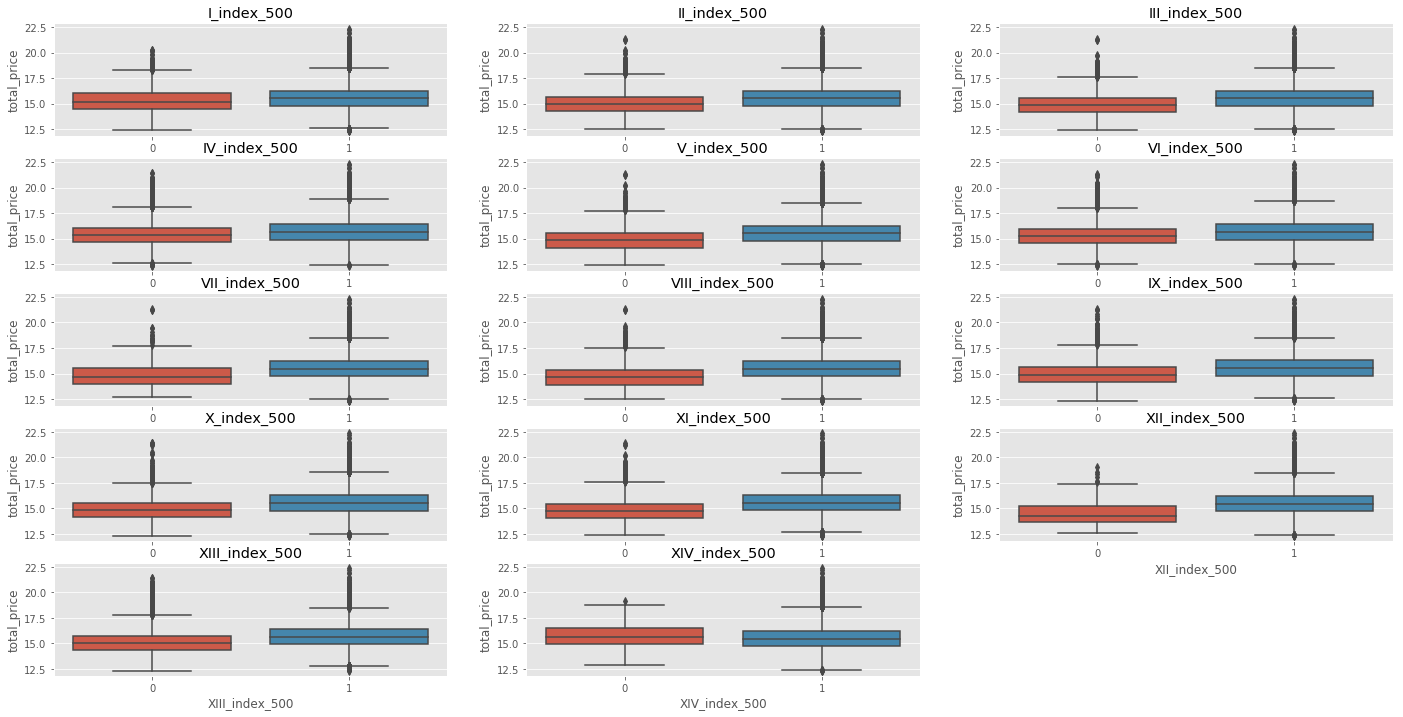

In [29]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_500')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], np.log1p(train['total_price']))

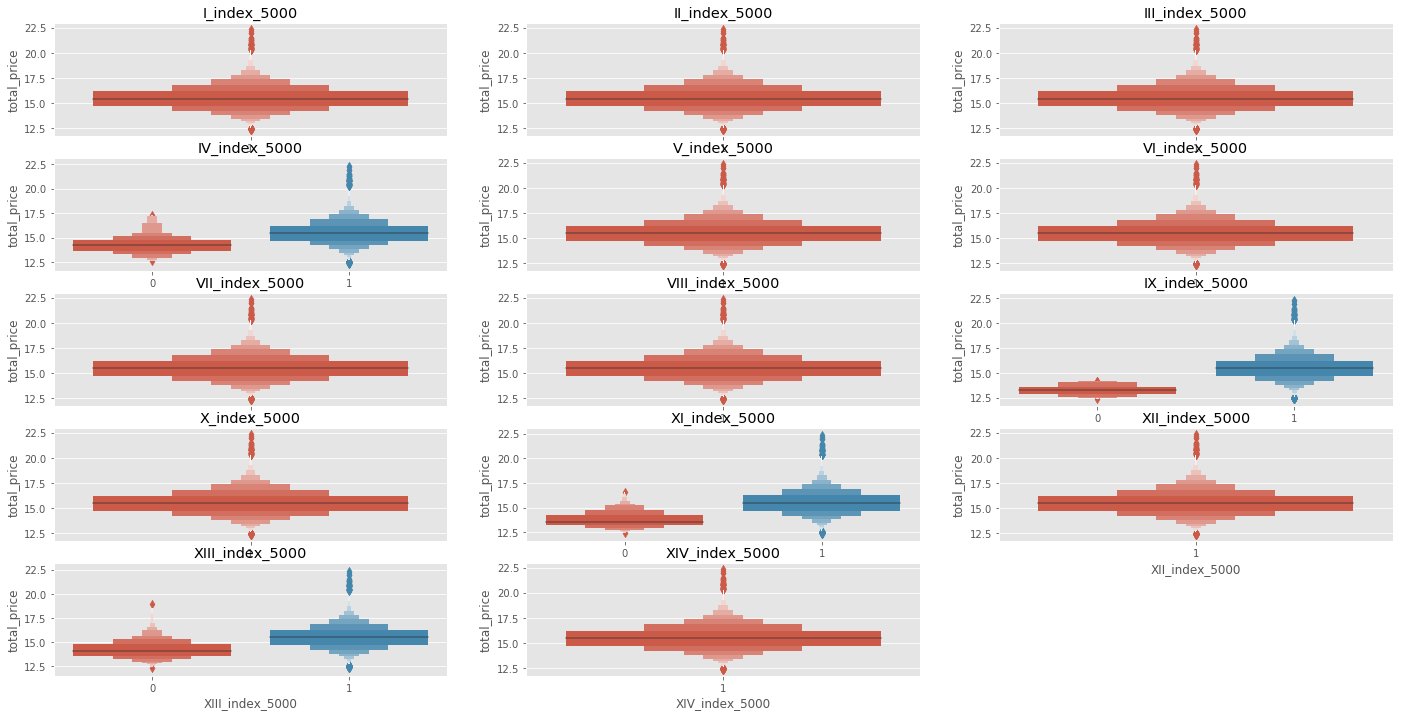

In [30]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_5000')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxenplot(train[col], np.log1p(train['total_price']))

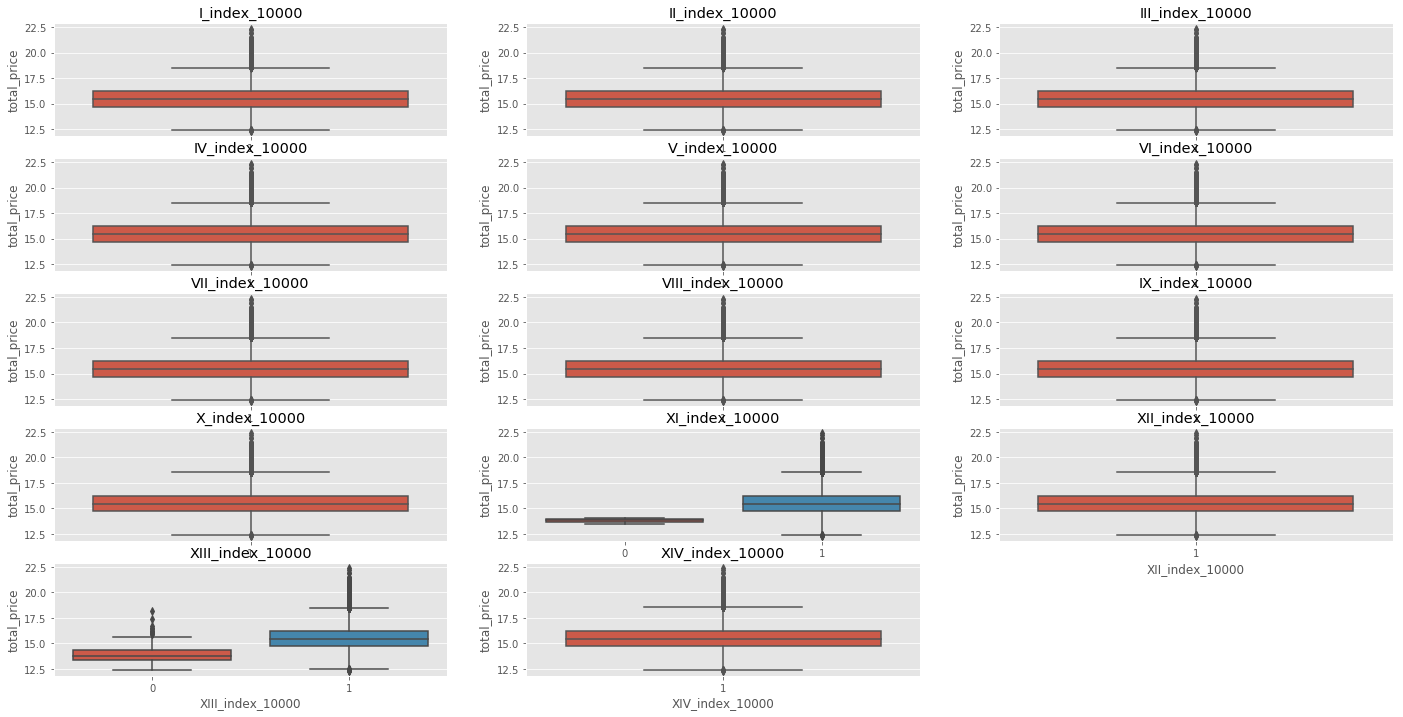

In [31]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_10000')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], np.log1p(train['total_price']))

In [175]:
len([i for i in train.columns if np.sum(train[i]) == 60000 and 'index' in i])

22

In [35]:
train['village_income_median'].isna().sum()

1142

In [38]:
train.groupby(['city'])['village_income_median'].median()

city
3     593.0
5     589.0
6     568.0
7     618.0
9     770.0
10    668.0
12    614.0
13    746.0
14    615.0
17    627.0
21    624.0
Name: village_income_median, dtype: float64

In [37]:
train.groupby(['city'])['village_income_median'].mean()

city
3      597.345633
5      588.768020
6      568.731400
7      646.278368
9     1035.359111
10     686.269449
12     635.886657
13     770.654135
14     642.978935
17     630.751546
21     647.720324
Name: village_income_median, dtype: float64

In [40]:
train['village_income_median'].head()

0    572.0
1    550.0
2    625.0
3    950.0
4    536.0
Name: village_income_median, dtype: float64

In [88]:
for city in train['city'].unique():
    print(city)
    temp = train.loc[(train['city'] ==city)]
    high = temp['total_price'].mean() + temp['total_price'].std()
    low  = temp['total_price'].mean() - temp['total_price'].std()
    print(len(temp[(temp['total_price'] > high) | (temp['total_price'] < low)]))
    print('-'*100)

21
148
----------------------------------------------------------------------------------------------------
7
311
----------------------------------------------------------------------------------------------------
12
287
----------------------------------------------------------------------------------------------------
17
25
----------------------------------------------------------------------------------------------------
10
249
----------------------------------------------------------------------------------------------------
13
330
----------------------------------------------------------------------------------------------------
14
143
----------------------------------------------------------------------------------------------------
3
68
----------------------------------------------------------------------------------------------------
6
40
----------------------------------------------------------------------------------------------------
5
28
-----------------------------

In [74]:
train.groupby(['city'])['total_price'].median()

city
3     1.648821e+06
5     1.235981e+06
6     2.585255e+06
7     6.521007e+06
9     4.892756e+06
10    3.321452e+06
12    4.120926e+06
13    1.546996e+07
14    2.727088e+06
17    2.432564e+06
21    2.432520e+06
Name: total_price, dtype: float64

In [19]:
inter_cols = ['building_type', 'parking_way', 'building_use', 'building_material']
for i in range(4):
        for j in range(4):
            if j > i:
                print(i,j)
                
                
                
                
                

0 1
0 2
0 3
1 2
1 3
2 3


In [77]:
len(train.columns)

235

In [84]:
train.groupby(['city'])['building_type'].size()

city
3       813
5      1224
6       826
7     19664
9      1125
10     4676
12     7264
13    10756
14     4704
17      984
21     7964
Name: building_type, dtype: int64

In [28]:
?sns.boxenplot

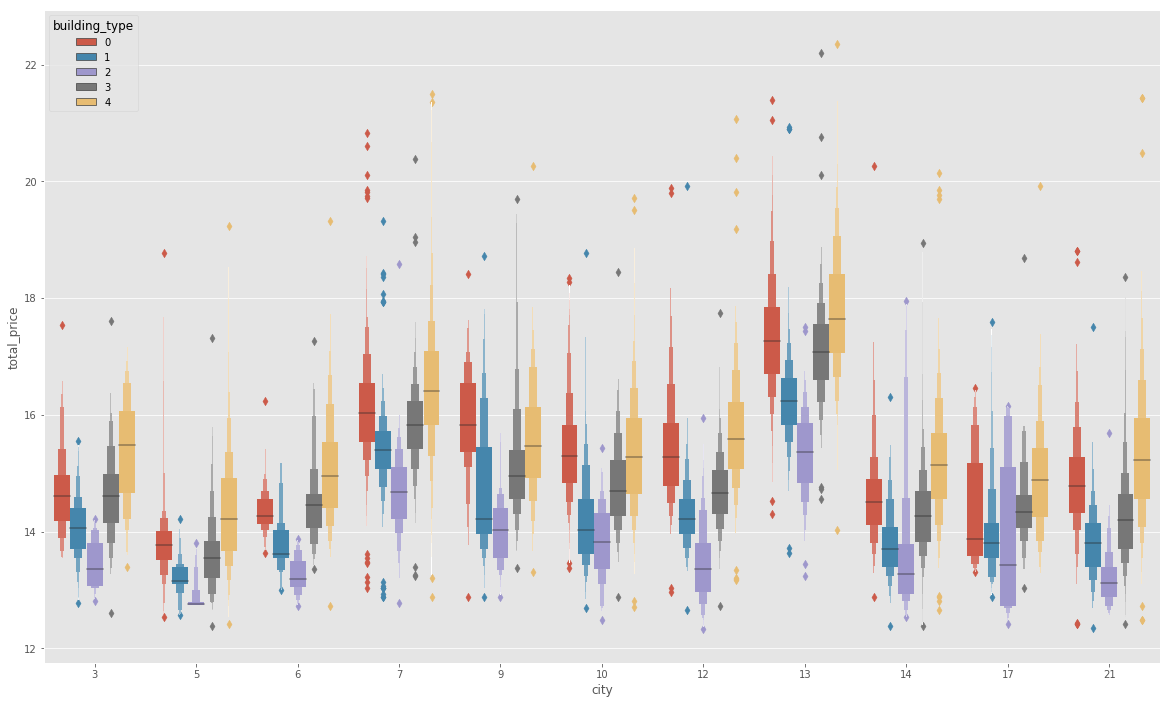

In [32]:
fig = plt.figure(figsize=(20,12))
sns.boxenplot(x = train['city'],y = np.log1p(train['total_price']), hue = train['building_type'])

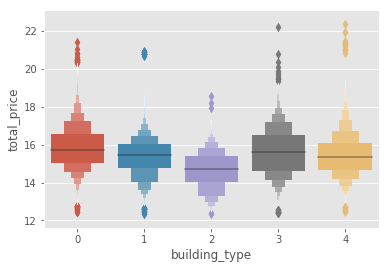

In [4]:
sns.boxenplot(train['building_type'], np.log1p(train['total_price']))

In [19]:
temp = train[train['building_type'] == 4]


In [11]:
train.groupby(['building_type'])['parking_area'].apply(lambda x : x.isna().sum())

building_type
0    13694
1    14957
2     2709
3     9664
4    15873
Name: parking_area, dtype: int64

In [13]:
train.groupby(['building_type'])['land_area'].mean()

building_type
0    12.750181
1    18.255778
2     5.363923
3    16.718784
4    64.492532
Name: land_area, dtype: float64

In [14]:
train.groupby(['building_type'])['land_area'].std()

building_type
0     22.433230
1     11.971430
2      8.446363
3     14.779095
4    105.488234
Name: land_area, dtype: float64

In [15]:
train.groupby(['building_type'])['building_area'].mean()

building_type
0    11.202060
1     5.617327
2     2.419849
3     9.191861
4    15.537716
Name: building_area, dtype: float64

In [16]:
train.groupby(['building_type'])['building_area'].std()

building_type
0    12.830742
1     8.209869
2     6.314876
3    15.273151
4    50.548065
Name: building_area, dtype: float64

In [18]:
test.groupby(['building_type'])['building_area'].mean()

building_type
0    11.364261
1     5.592143
2     2.714495
3     9.259168
4    17.151488
Name: building_area, dtype: float64

In [30]:
train['building_use'].value_counts()

2     51312
1      3069
5      2575
8      1014
6       752
10      722
0       369
3       119
7        37
4        31
Name: building_use, dtype: int64

In [40]:
train['total_floor'].isna().sum(), train['txn_floor'].isna().sum()

(0, 15902)

In [49]:
train.building_type.value_counts()

4    15902
0    15691
1    15049
3    10536
2     2822
Name: building_type, dtype: int64

In [59]:
FE_train.groupby(['building_material'])['total_price'].mean().reset_index().sort_values('total_price')

,building_material,total_price
0,1,1.012425e+07
2,8,1.222836e+07
1,2,6.712714e+07


In [60]:
FE_train.groupby(['building_material'])['total_price'].median().reset_index().sort_values('total_price')

,building_material,total_price
0,1,3.510815e+06
2,8,5.596452e+06
1,2,9.035414e+06


In [62]:
train['total_price'].max(), train['total_price'].min()

(5088279096.76905, 226149.5239862996)

In [66]:
outlier = train['total_price'].quantile(0.75) + (train['total_price'].quantile(0.75) - train['total_price'].quantile(0.25)) * 1.5 

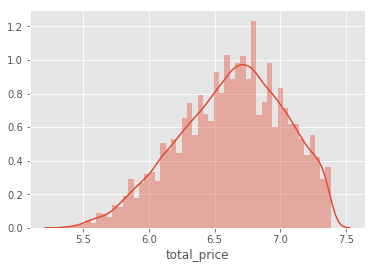

In [69]:

sns.distplot(np.log10(train[train['total_price'] < outlier]['total_price']))

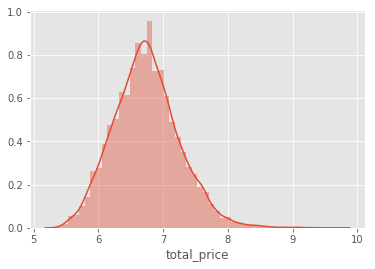

In [63]:
sns.distplot(np.log10(train['total_price']))

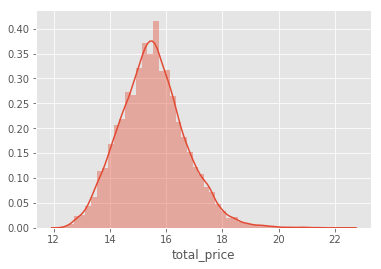

In [64]:
sns.distplot(np.log1p(train['total_price']))

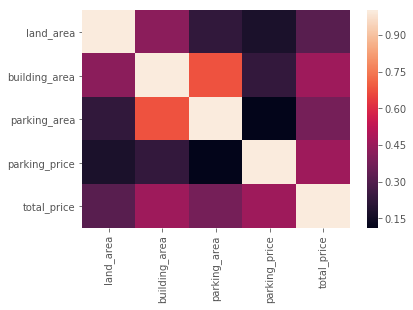

In [73]:
sns.heatmap(train[['land_area', 'building_area', 'parking_area', 'parking_price', 'total_price']].corr())

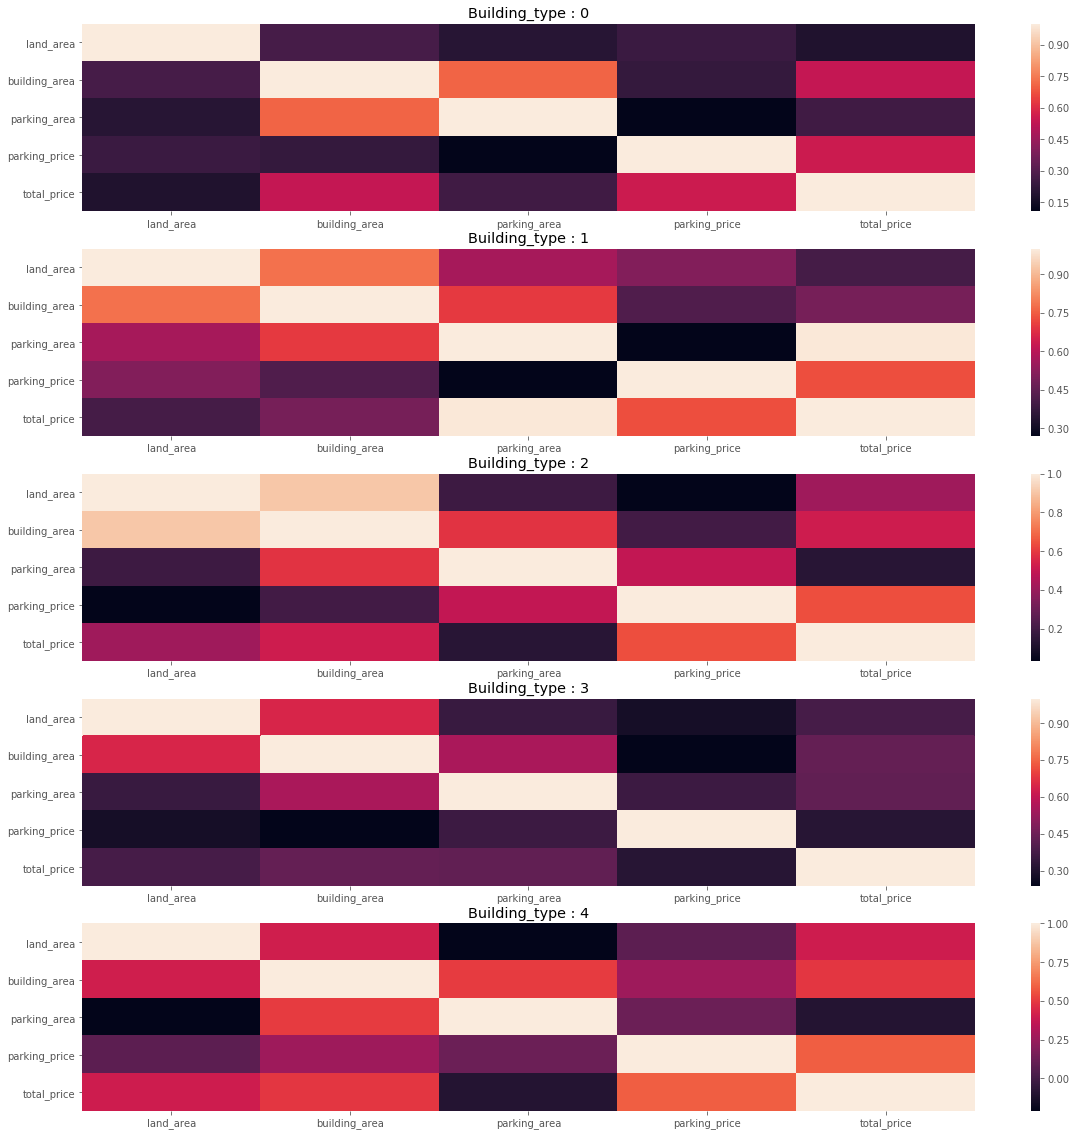

In [119]:
fig = plt.figure(figsize=(20,20))
for i in range(5):
    ax = fig.add_subplot(5,1,i+1)
    sns.heatmap(train[train['building_type'] == i][['land_area', 'building_area', 'parking_area', 'parking_price', 'total_price']].corr())
    ax.set_title('Building_type : {}'.format(i))

In [101]:
train[train['building_type'] == 0][['land_area', 'building_area', 'parking_area', 'parking_price', 'total_price']].corr()

,land_area,building_area,parking_area,parking_price,total_price
land_area,1.000000,0.272728,0.201279,0.245209,0.182469
building_area,0.272728,1.000000,0.708067,0.233374,0.537692
parking_area,0.201279,0.708067,1.000000,0.108821,0.259388
parking_price,0.245209,0.233374,0.108821,1.000000,0.555802
total_price,0.182469,0.537692,0.259388,0.555802,1.000000


In [100]:
train[train['building_type'] == 1][['land_area', 'building_area', 'parking_area', 'parking_price', 'total_price']].corr()

,land_area,building_area,parking_area,parking_price,total_price
land_area,1.000000,0.781715,0.570643,0.509210,0.402201
building_area,0.781715,1.000000,0.698287,0.421094,0.490540
parking_area,0.570643,0.698287,1.000000,0.268491,0.992747
parking_price,0.509210,0.421094,0.268491,1.000000,0.730264
total_price,0.402201,0.490540,0.992747,0.730264,1.000000


In [102]:
train[train['building_type'] == 2][['land_area', 'building_area', 'parking_area', 'parking_price', 'total_price']].corr()

,land_area,building_area,parking_area,parking_price,total_price
land_area,1.000000,0.908002,0.191060,0.033362,0.416692
building_area,0.908002,1.000000,0.586361,0.199859,0.523981
parking_area,0.191060,0.586361,1.000000,0.497701,0.139019
parking_price,0.033362,0.199859,0.497701,1.000000,0.643515
total_price,0.416692,0.523981,0.139019,0.643515,1.000000


In [76]:
train['parking_area'].isna().sum()

56897

In [80]:
train[train['parking_area'].isna()]['building_type'].value_counts()

4    15873
1    14957
0    13694
3     9664
2     2709
Name: building_type, dtype: int64

In [83]:
train[train['parking_area'].notna()]['building_type'].value_counts()

0    1997
3     872
2     113
1      92
4      29
Name: building_type, dtype: int64

In [84]:
train[train['parking_area'].isna()]['city'].value_counts()

7     18467
13    10097
21     7818
12     6843
14     4653
10     4215
5      1219
9      1010
17      981
6       808
3       786
Name: city, dtype: int64

In [86]:
train[train['parking_area'].isna()]['parking_way'].value_counts()

2    46065
0     8387
1     2445
Name: parking_way, dtype: int64

In [87]:
train[train['parking_area'].notna()]['parking_way'].value_counts()

0    2536
1     567
Name: parking_way, dtype: int64

In [90]:
train[train['parking_area'].isna()]['building_use'].value_counts()

2     48641
1      3055
5      2366
8       967
6       749
10      593
0       361
3       119
7        35
4        11
Name: building_use, dtype: int64

In [93]:
train[train['parking_area'].notna()]['building_use'].value_counts()

2     2671
5      209
10     129
8       47
4       20
1       14
0        8
6        3
7        2
Name: building_use, dtype: int64

In [127]:
train[['total_floor', 'building_type']].head(10)

,total_floor,building_type
0,4,3
1,5,1
2,4,1
3,24,0
4,2,4
5,5,1
6,15,0
7,8,3
8,5,1
9,10,3


In [130]:
train[['txn_floor', 'total_floor', 'building_type']].head(50)

,txn_floor,total_floor,building_type
0,3.0,4,3
1,5.0,5,1
2,1.0,4,1
3,13.0,24,0
4,NaN,2,4
5,4.0,5,1
6,8.0,15,0
7,4.0,8,3
8,1.0,5,1
9,2.0,10,3


In [7]:
len(train['building_complete_dt'].unique())

658

In [8]:
len(train['txn_dt'].unique())

1782

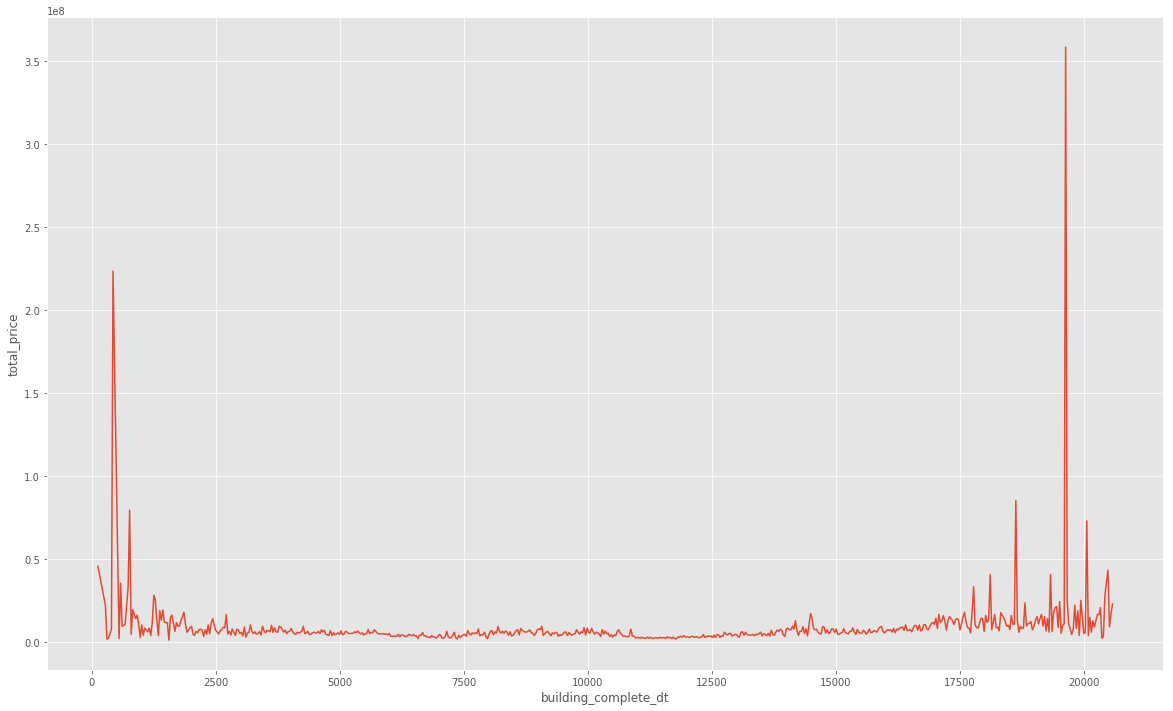

In [8]:
qq = train.groupby(['building_complete_dt'])['total_price'].median().reset_index()
fig = plt.figure(figsize=(20,12))
sns.lineplot(qq['building_complete_dt'], qq['total_price'])

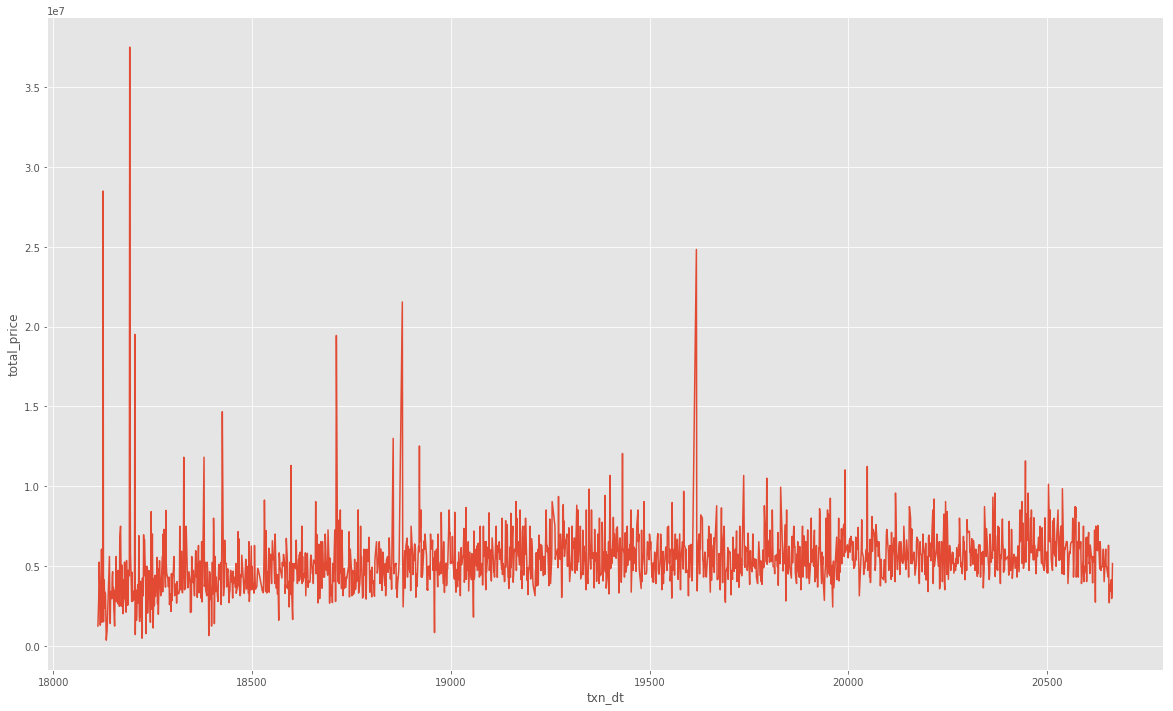

In [7]:
qq = train.groupby(['txn_dt'])['total_price'].median().reset_index()
fig = plt.figure(figsize=(20,12))
sns.lineplot(qq['txn_dt'], qq['total_price'])

In [17]:
train[(train['building_complete_dt'] > 2500) & (train['building_complete_dt'] < 17500)]

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469803,6.476038e+05
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.073573,3.321452e+06
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.462081,9.570885e+06
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.131236,7.627120e+05
5,HmW2MkrwafmceWAH,8,21,18394,5,1,2,6576,2,NaN,...,58,1,314,1,2725,1,7417,1,61.109908,3.964520e+05
6,ITYyim3zx6DQyCoF,8,7,20474,15,0,2,16559,0,NaN,...,65,1,252,1,11515,1,26867,1,196.690224,8.510296e+06
7,KFrxqaWZaLynrOae,8,12,18185,8,3,2,11934,1,NaN,...,64,1,181,1,11456,1,19514,1,66.780308,1.678426e+06
8,ZiK0gY7A0BvwZ8OV,8,21,18794,5,1,2,7640,2,NaN,...,116,1,203,1,2666,1,7014,1,40.349486,9.870214e+05
9,QnytA7FbgaVxIDuP,8,7,19927,10,3,2,9863,0,NaN,...,118,1,288,1,12945,1,32664,1,102.955013,1.181540e+07
10,jcbuA8q3KPH9SzpS,1,7,18333,2,4,2,7763,2,NaN,...,34,1,253,1,6445,1,25744,1,110.890233,7.642884e+06


In [18]:
test[(test['building_complete_dt'] > 2500) & (test['building_complete_dt'] < 17500)]

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
1,BTshNOJyKHnT2YIT,8,7,20199,10,3,2,16011,2,NaN,...,18,44,1,67,1,1950,1,10725,1,100.819809
4,wmUeMoJZfsqaSX9b,8,3,18164,13,0,2,13272,2,NaN,...,4,18,1,76,1,1346,1,3280,1,181.213095
5,EtBjGAHmHCe9t7TZ,8,12,18632,4,4,2,15464,2,NaN,...,7,19,1,88,1,2144,1,5477,1,206.701060
6,hPNH34vmaZtvBtqc,8,7,19144,14,0,2,16590,0,NaN,...,17,64,1,380,1,9419,1,23499,1,77.249329
7,wXjeI38bYDMJJwZC,8,13,19452,5,1,2,7124,2,NaN,...,3,22,1,273,1,2729,1,12880,1,155.031982
8,fxZSGX6aPAFKU8W4,1,17,19045,2,4,2,12634,2,NaN,...,2,11,1,27,1,459,1,1693,1,81.407991
9,ewr0Fx6ign87OwaV,8,7,19220,13,2,10,17351,2,NaN,...,4,17,1,127,1,5742,1,23399,1,16.357214
10,gHKurnEP4AowzsLg,8,10,20045,5,1,2,8159,2,NaN,...,6,37,1,140,1,2957,1,10616,1,106.945487
11,PmLfTgY2FElLrTl0,8,7,18222,5,1,2,10167,2,NaN,...,16,44,1,123,1,15822,1,32511,1,0.490817
12,eM2NppIOwzW0o8iy,8,7,20614,14,0,2,14095,0,7.180619,...,15,63,1,217,1,2797,1,6553,1,47.922058


In [10]:
train[train.parking_area == 0].head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
7540,DaXt6glhwsIMcDgZ,10,7,18533,19,0,2,17837,1,0.0,...,56,1,144,1,6489,1,27774,1,75.881635,9.013963e+06
9821,jtapRNfblVzjGbhW,8,14,20060,8,3,2,11081,1,0.0,...,43,1,226,1,4793,1,14010,1,18.301608,1.796452e+06
20916,jAyRTPpE0pq2FJzR,10,7,19922,19,0,5,17837,1,0.0,...,57,1,145,1,6216,1,26029,1,31.099876,6.807744e+06
37213,AImVRVfMH81vT9j1,8,13,20626,15,0,2,18294,1,0.0,...,38,1,111,1,6708,1,26297,1,26.893580,2.225728e+07
39031,r7cDtolWm9cJRsT8,10,7,18926,19,2,2,17837,1,0.0,...,58,1,141,1,6464,1,27561,1,49.246510,4.304371e+06


In [16]:
MIN_cols = [i for i in train.columns if '_MIN' in i]

In [25]:
train[MIN_cols].apply(lambda x : x.rank(), axis =1 )

,I_MIN,II_MIN,III_MIN,IV_MIN,V_MIN,VI_MIN,VII_MIN,VIII_MIN,IX_MIN,X_MIN,XI_MIN,XII_MIN,XIII_MIN,XIV_MIN
0,7.0,8.0,2.0,14.0,12.0,13.0,10.0,6.0,5.0,4.0,11.0,3.0,9.0,1.0
1,9.0,8.0,2.0,14.0,6.5,13.0,1.0,6.5,10.0,12.0,11.0,3.0,4.0,5.0
2,9.0,12.0,10.0,7.0,6.0,1.0,4.0,2.0,8.0,11.0,13.0,3.0,14.0,5.0
3,12.0,8.0,3.0,13.0,11.0,10.0,7.0,5.0,4.0,1.0,9.0,2.0,14.0,6.0
4,6.0,1.0,5.0,12.0,9.0,14.0,8.0,4.0,11.0,10.0,7.0,3.0,13.0,2.0
5,5.0,11.0,6.0,14.0,10.0,12.0,3.0,4.0,9.0,7.0,8.0,1.0,13.0,2.0
6,11.0,10.0,2.0,14.0,5.5,12.0,4.0,5.5,3.0,7.0,8.0,1.0,13.0,9.0
7,8.0,1.5,1.5,14.0,10.0,11.0,4.0,9.0,3.0,13.0,5.0,6.0,12.0,7.0
8,7.0,13.0,4.0,9.0,1.5,12.0,1.5,5.0,11.0,8.0,10.0,6.0,14.0,3.0
9,7.0,11.0,3.0,13.0,9.5,14.0,2.0,9.5,6.0,8.0,1.0,4.0,12.0,5.0
